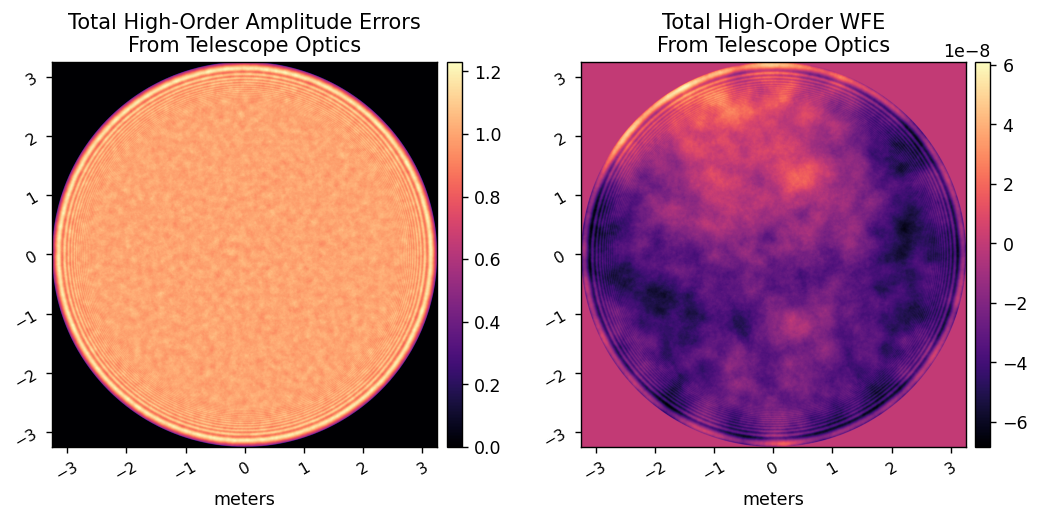

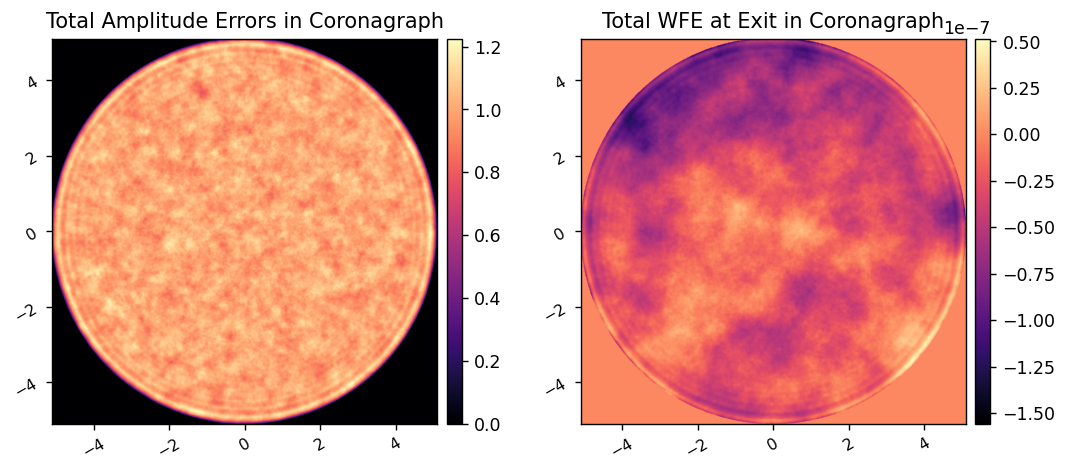

In [5]:
import sys
sys.path.append('..')

import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fresnel_coro_poppy as fresnel
import apra_pop_models.fraunhofer_coro_poppy as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array

import lina
from lina.imshows import *

pupil_diam = 10.2*u.mm
wavelength_c = 650e-9*u.m

focal_ratio = 350/500 # focal lengths of relay OAPs from DM pupil to 
lyot_diam = 0.85 * pupil_diam *focal_ratio

# Load in the OTE WFE for the full model of the coronagraph
ote_wfe_fname = '../ote-wfe-data/telescope_wfe.fits'
wfe_hdu = fits.open(ote_wfe_fname)
wfe = xp.array(wfe_hdu[0].data)
wfe_pxscl = wfe_hdu[0].header['PIXELSCL'] * u.m/u.pix
wfe_hdu.close()
OTE_WFE = poppy.ArrayOpticalElement(transmission=wfe[0], opd=wfe[1], pixelscale=wfe_pxscl,)
imshow2(OTE_WFE.amplitude, OTE_WFE.opd, 
        'Total High-Order Amplitude Errors\nFrom Telescope Optics', 'Total High-Order WFE\nFrom Telescope Optics', 
#         pxscl=OTE_WFE.pixelscale.to(u.mm/u.pix),
        pxscl=6.5/wfe.shape[1], xlabel='meters',
       )

# Load in the pupil plane wfe from the compact model of the coronagraph
wfe_fits = fits.open('../phase-retrieval-data/post_fpm_pupil_wfe.fits')
coro_wfe = np.fliplr(wfe_fits[0].data)
wfe_pxscl = wfe_fits[0].header['PIXELSCL'] * u.m/u.pix
wfe_fits.close()
CORO_WFE = poppy.ArrayOpticalElement(transmission=coro_wfe[0], opd=coro_wfe[1],pixelscale=wfe_pxscl,)
imshow2(CORO_WFE.amplitude, CORO_WFE.opd, 
        'Total Amplitude Errors in Coronagraph', 'Total WFE at Exit in Coronagraph',
        pxscl=CORO_WFE.pixelscale.to(u.mm/u.pix))

# Test the match between the full model and the compact model

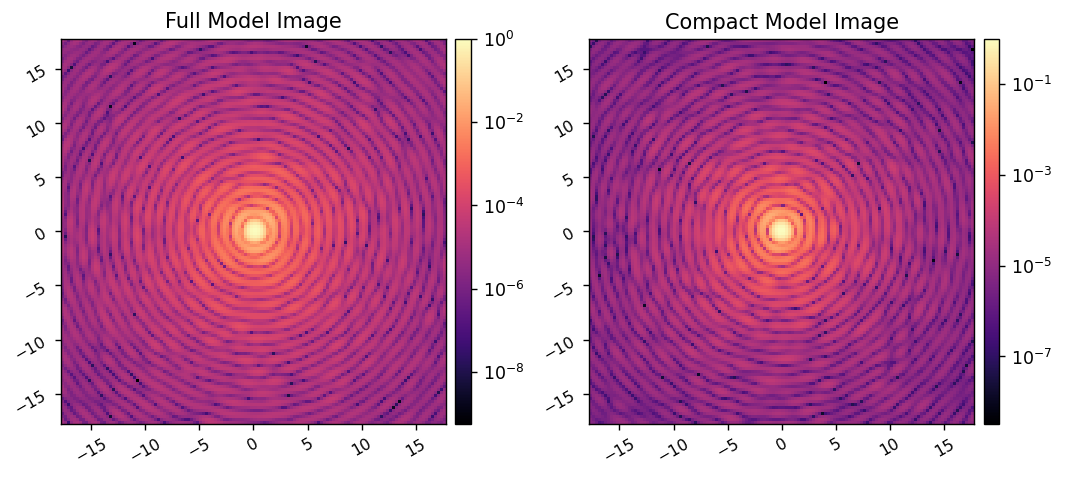

In [9]:
reload(fresnel)
reload(fraunhofer)

reload(agpm)

coro = fresnel.CORO()
coro.npix = 512
coro.oversample = 8
coro.npsf = 128
coro.use_opds = True
coro.OTEWFE = OTE_WFE

model = fraunhofer.CORO()
model.npix = 512
model.oversample = 8
model.npsf = 128
model.RETRIEVED = CORO_WFE

coro.im_norm = coro.snap().max()
model.im_norm = model.snap().max()

ref_psf = coro.snap()
model_psf = model.snap()

imshow2(ref_psf, model_psf, 'Full Model Image', 'Compact Model Image', lognorm=True,
             pxscl1=coro.psf_pixelscale_lamD, pxscl2=model.psf_pixelscale_lamD)

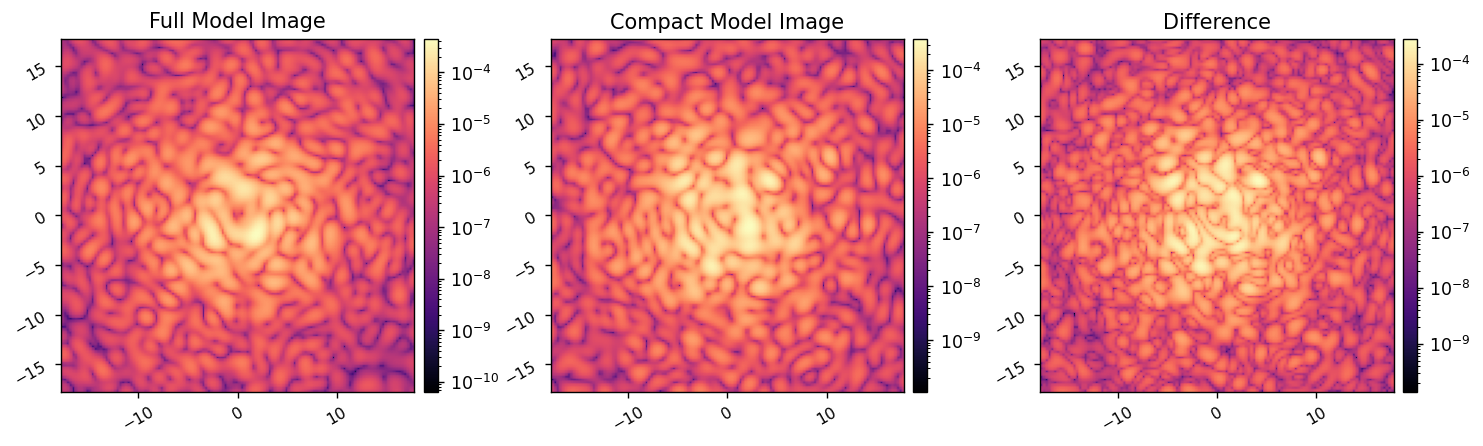

In [10]:
vortex = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6, singularity=20*u.um)
vortex_model = agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)

lyot_stop = poppy.CircularAperture(radius=lyot_diam/2)
lyot_stop_model = poppy.CircularAperture(radius=lyot_diam/2 / focal_ratio)

coro.FPM = vortex
coro.LYOT = lyot_stop

model.FPM = vortex_model
model.LYOT = lyot_stop_model

ref_im = coro.snap()
model_im = model.snap()

imshow3(ref_im, model_im, xp.abs(ref_im-model_im),
        'Full Model Image', 'Compact Model Image', 'Difference',
        lognorm1=True, lognorm2=True, lognorm3=True,
        pxscl=coro.psf_pixelscale_lamD)

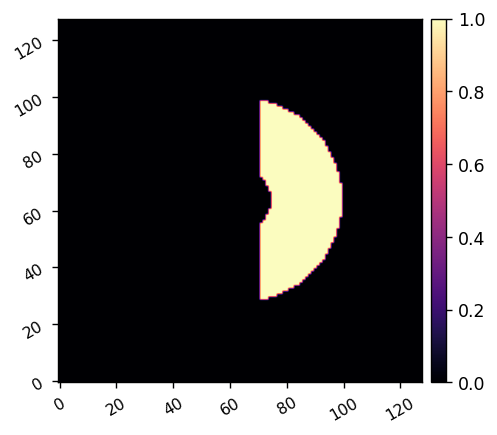

1482


In [13]:
control_mask = lina.utils.create_annular_focal_plane_mask(coro, inner_radius=3, outer_radius=10, edge=2, plot=True)

Nmask = int(control_mask.sum())
print(Nmask)

In [42]:
import matplotlib.pyplot as plt

In [15]:
poke_modes = lina.utils.create_all_poke_modes(coro.dm_mask)

Calculating Jacobian: 
	Calculated response for mode 952/952. Elapsed time=162.257 sec.
Jacobian built in 162.257 sec


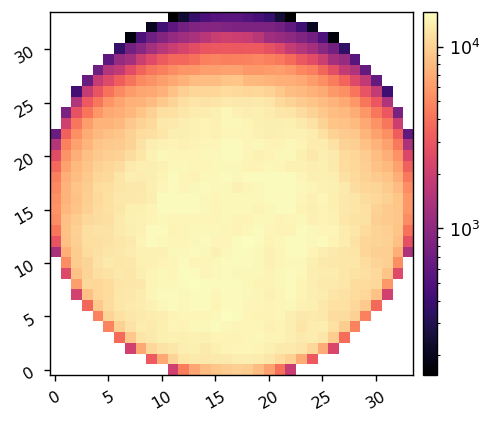

In [17]:
reload(lina.efc)

model.reset_dm()
coro.reset_dm()

amp = 1e-9 # poke amplitudes (DM surface)
jac = lina.efc.build_jacobian(model, poke_modes, amp, control_mask, plot=True)

In [6]:
jac = xp.array(fits.getdata('jacobians/compact_jacobian_20230703.fits'))

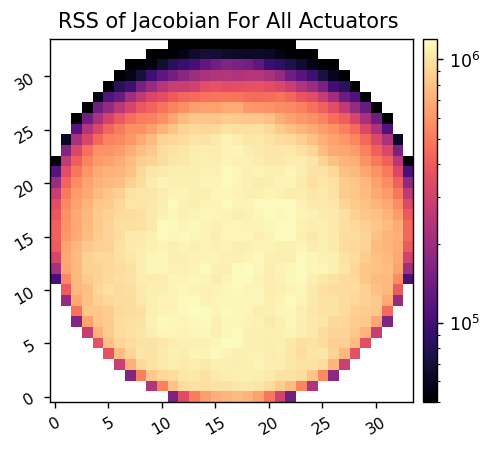

In [10]:
responses = jac[::2] + 1j*jac[1::2]
response = model.map_actuators_to_command(xp.sqrt(xp.sum(abs(responses)**2, axis=0)))
imshow1(response, 'RSS of Jacobian For All Actuators ', lognorm=True, vmin=5e4)

# Choose probes and test PWP

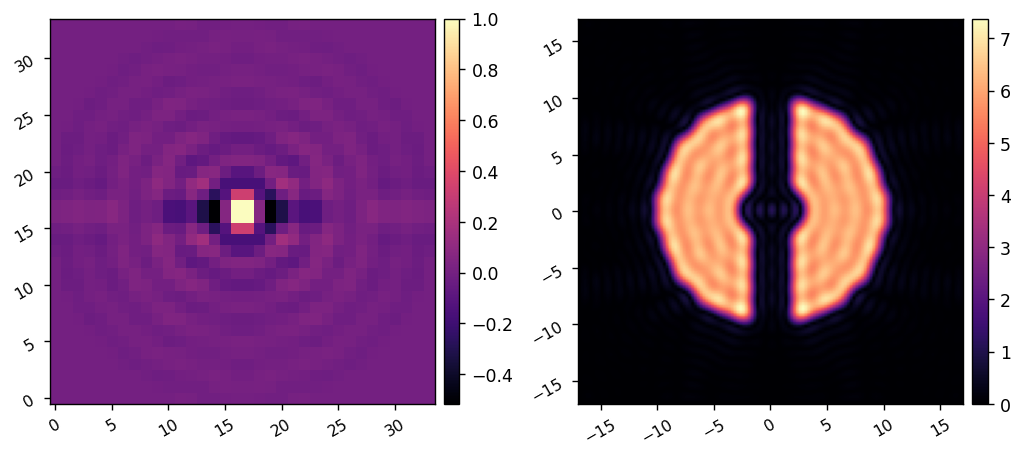

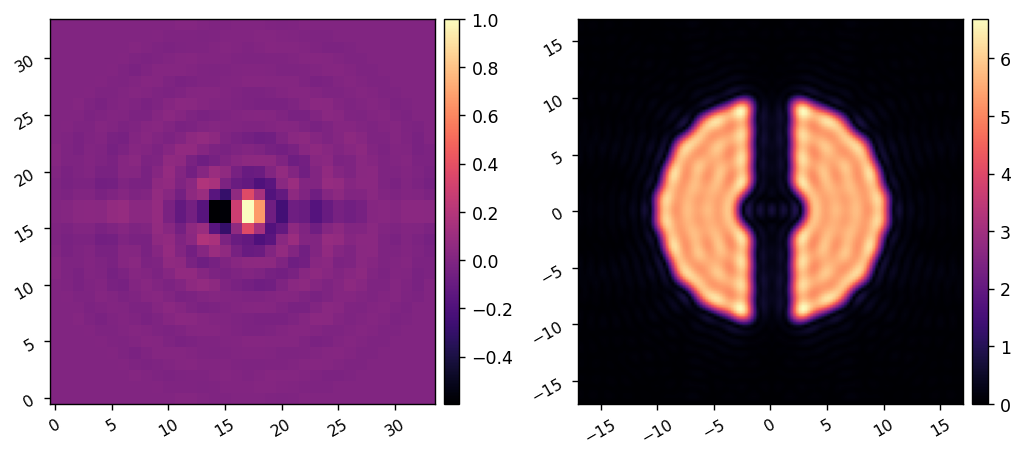

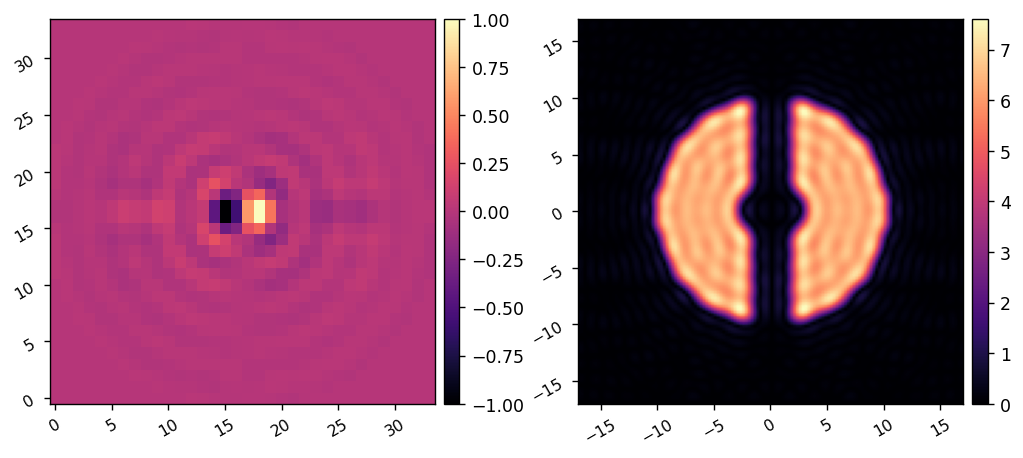

In [22]:
reload(lina.utils)
Npairs = 3
probe_amp = 25e-9
probe_modes = lina.utils.create_fourier_probes(coro, control_mask, nprobes=3, plot=True, calc_responses=True)
# imshow3(sin_probes[0], sin_probes[1], sin_probes[2])
# imshow2(sin_probes[0], sin_probes[1])


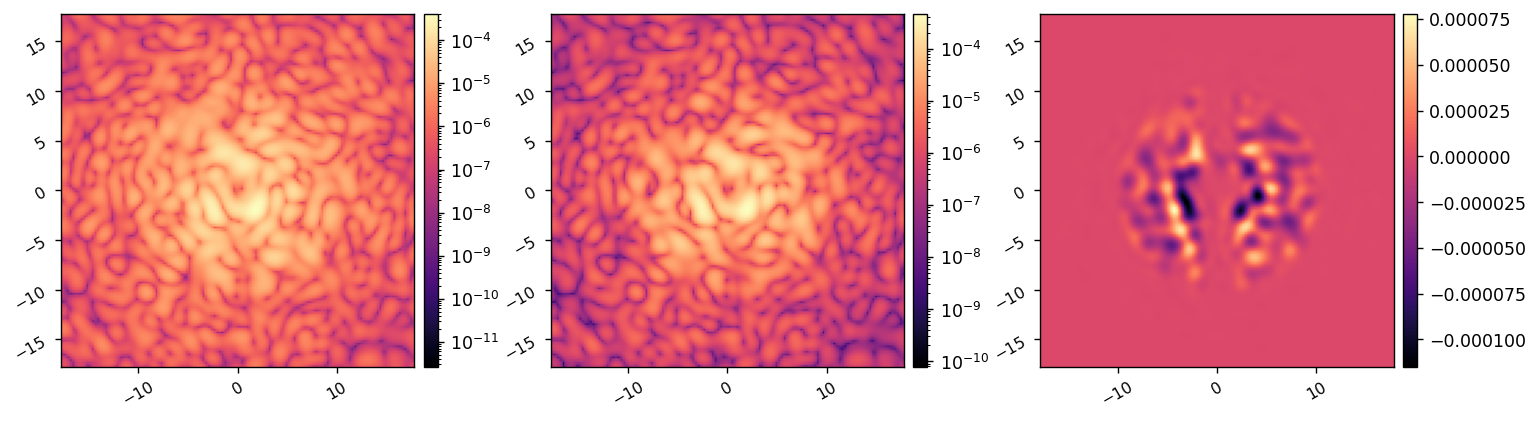

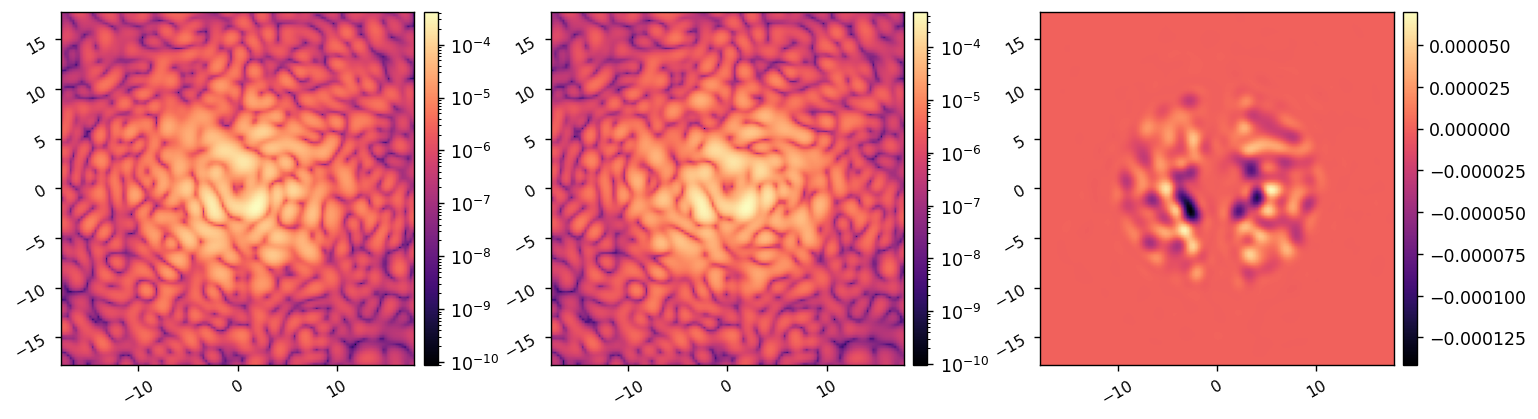

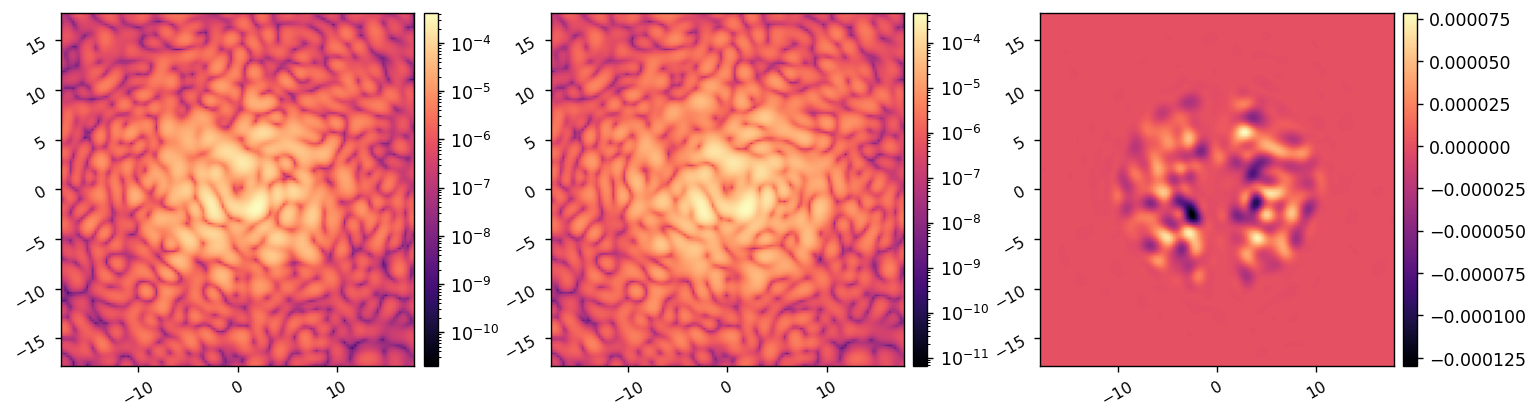

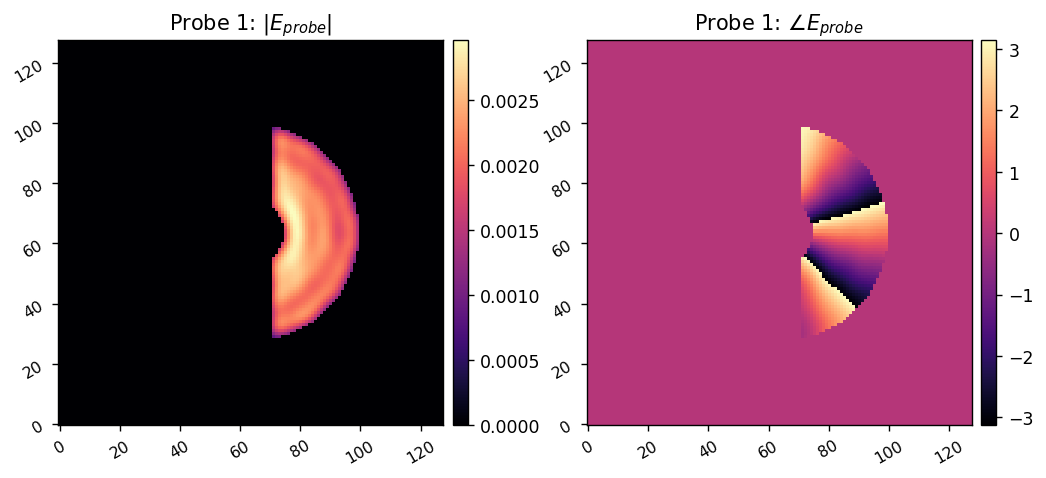

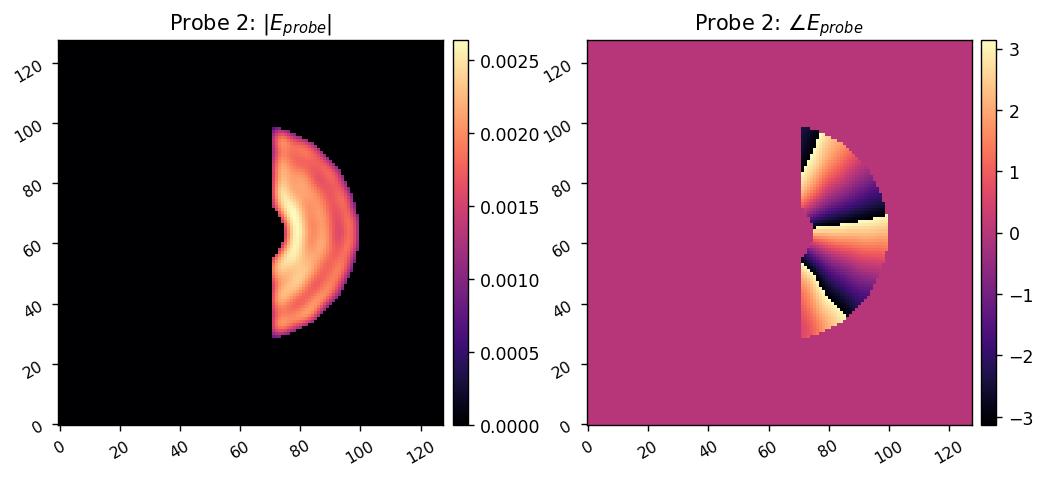

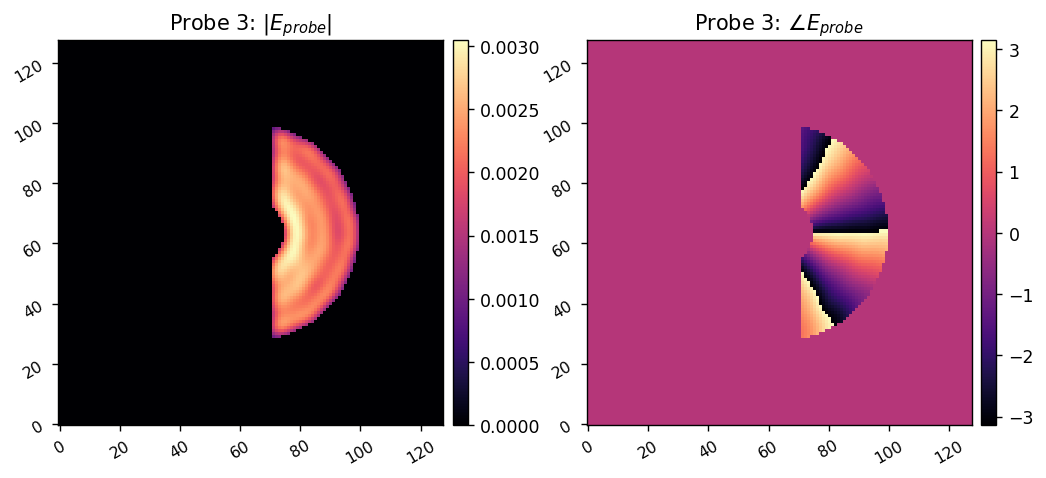

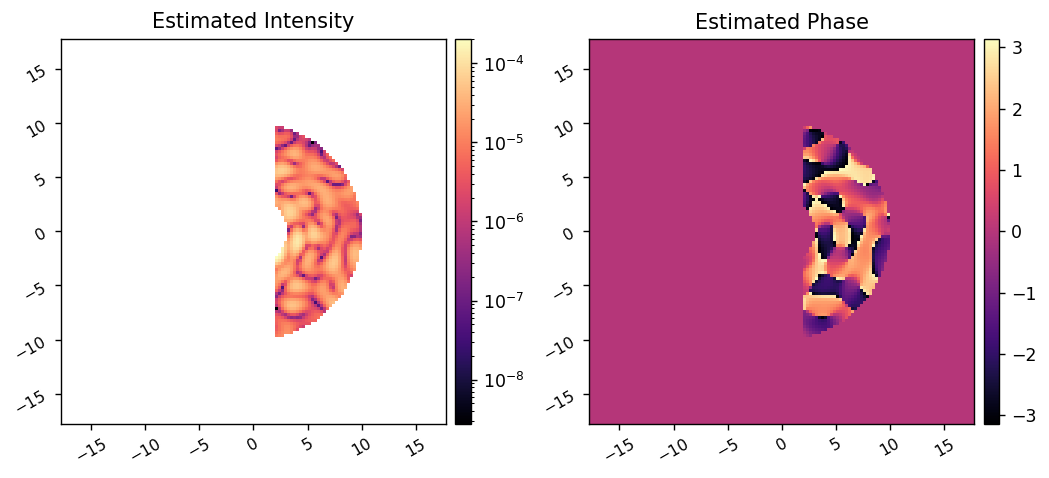

In [23]:
reload(lina.pwp)
coro.reset_dm()

est = lina.pwp.run_pwp_bp(coro, control_mask, probe_amp*probe_modes, use='J', jacobian=jac, plot=True)

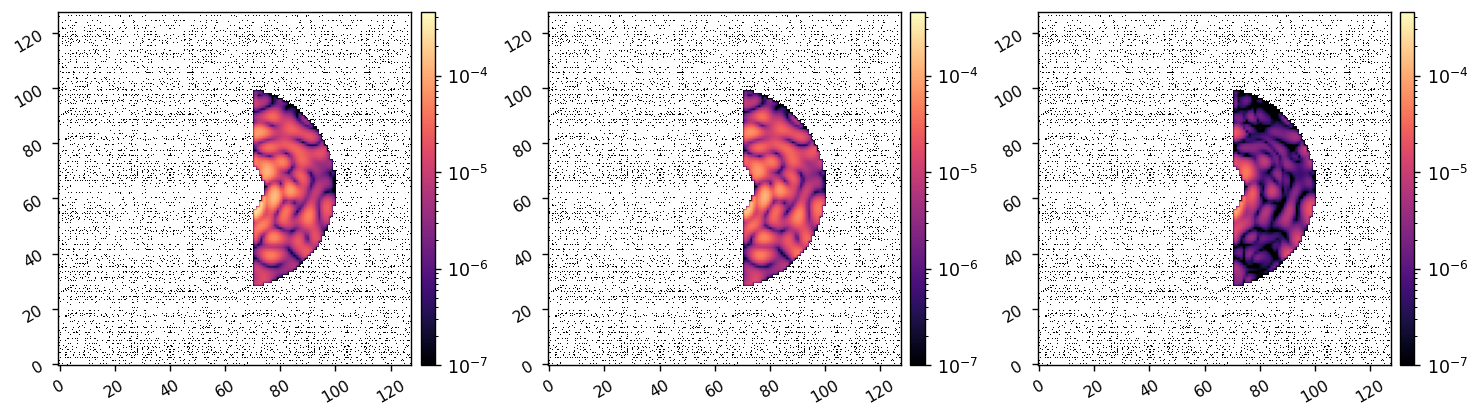

In [28]:
I_est = xp.abs(est)**2
diff = xp.abs(ref_im*control_mask - I_est)
imshow3(ref_im*control_mask, I_est, diff, lognorm=True, 
        vmax1=ref_im.max(), vmin1=1e-7, vmax2=ref_im.max(), vmin2=1e-7, vmax3=ref_im.max(), vmin3=1e-7)


# Run EFC with PWP

In [32]:
coro.reset_dm()
model.reset_dm()

images = xp.array([ref_im])
estimates = xp.array([est])
dm_commands = xp.array([coro.get_dm()])

In [40]:
pwp_fun = lina.pwp.run_pwp_bp

probe_amp=5e-9
pwp_params = {'probes':probe_modes*probe_amp, 'use':'J', 'jacobian':jac, 'plot':False, 'plot_est':True}

In [34]:
reg = 1e-2
# control_matrix = lina.utils.TikhonovInverse(jac, rcond=reg)
control_matrix = lina.utils.beta_reg(jac, -2)

Beginning closed-loop EFC simulation.
Max singular value squared:	 2236654514822.1577
alpha^2:			 358690673233.8554
	Running iteration 11/15.


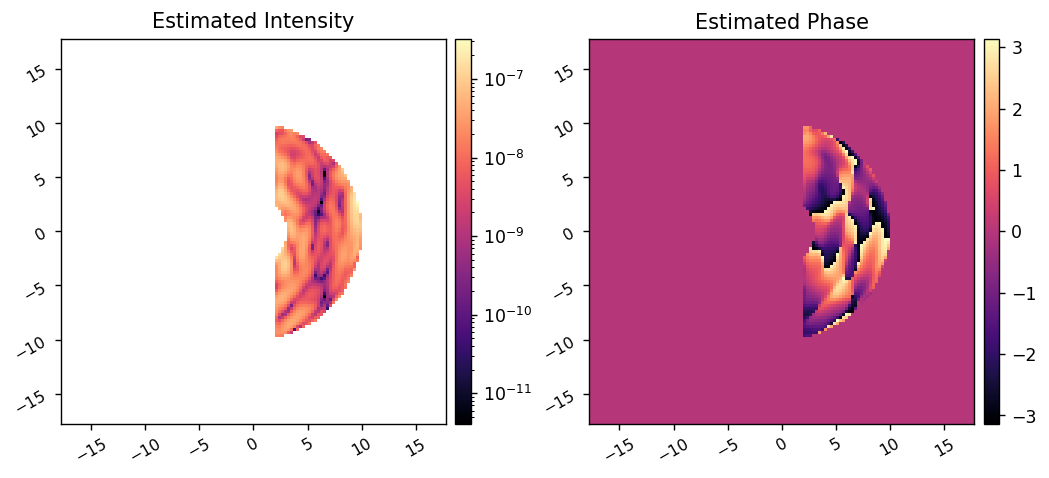

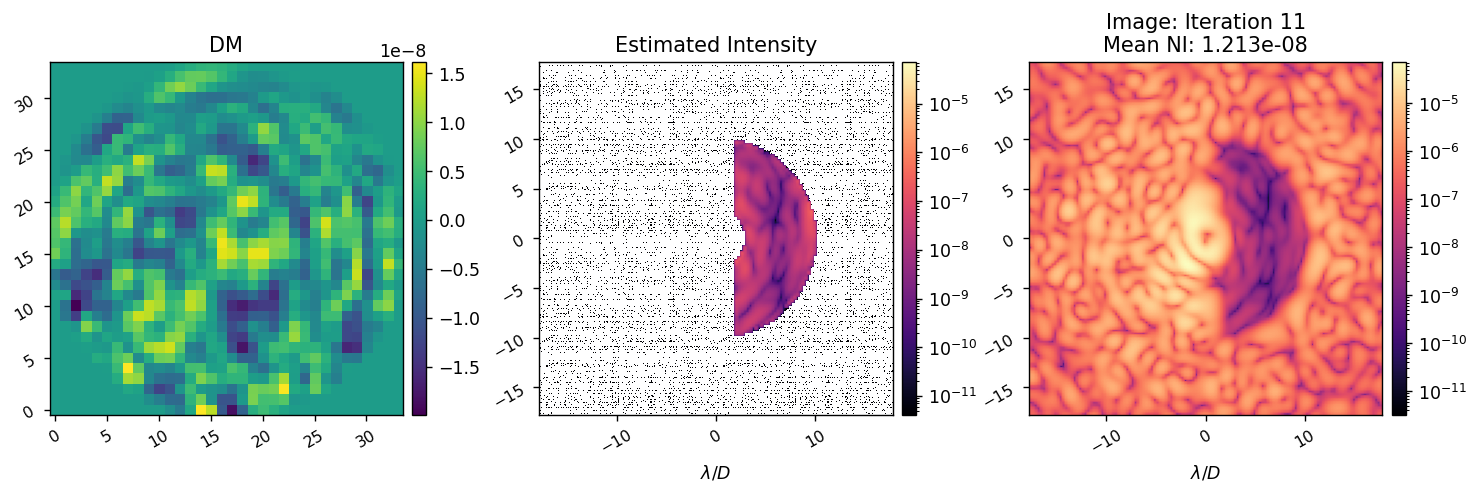

	Running iteration 12/15.


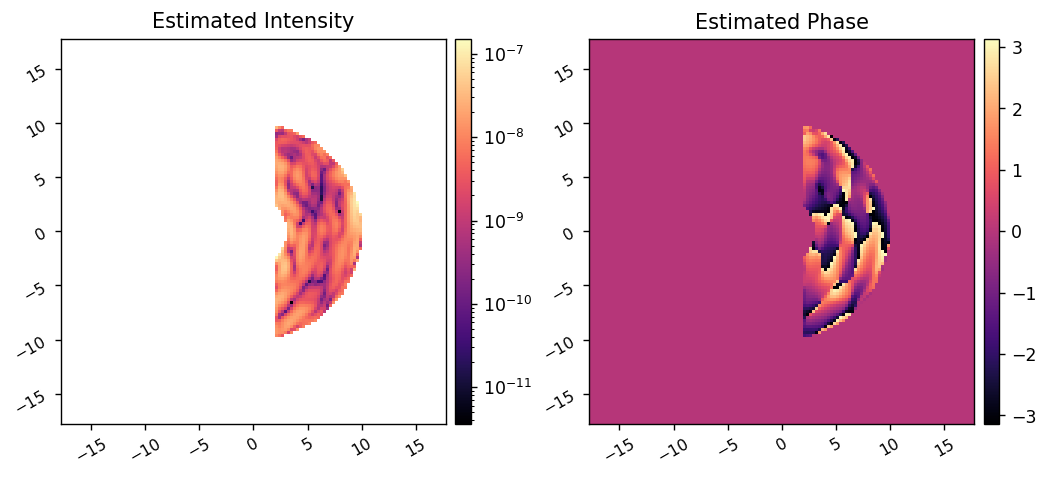

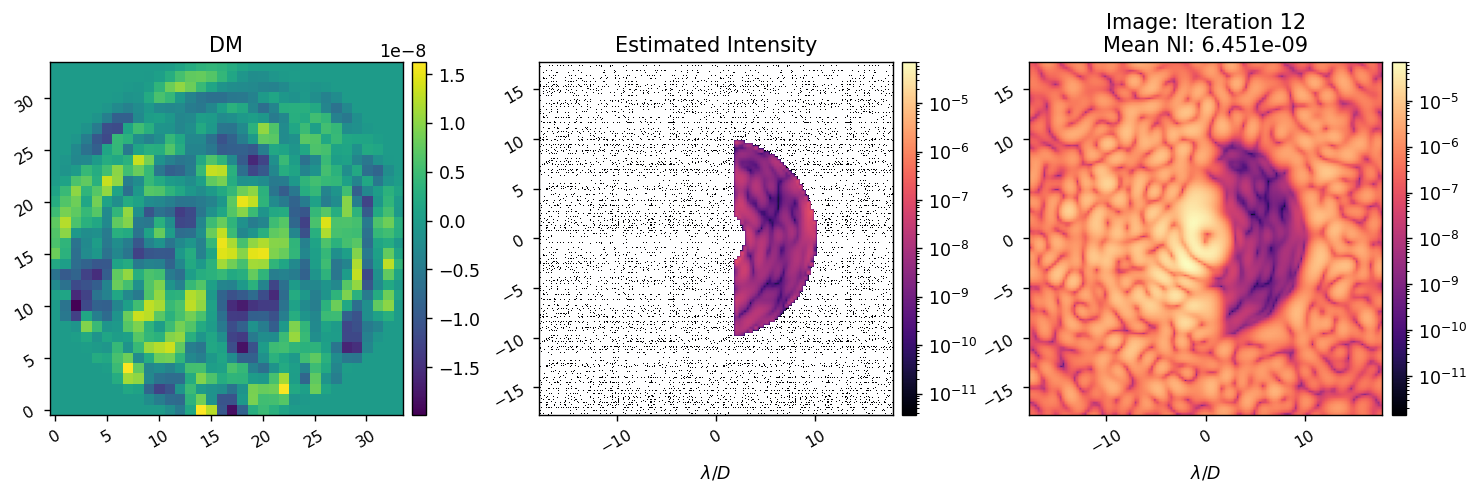

	Running iteration 13/15.


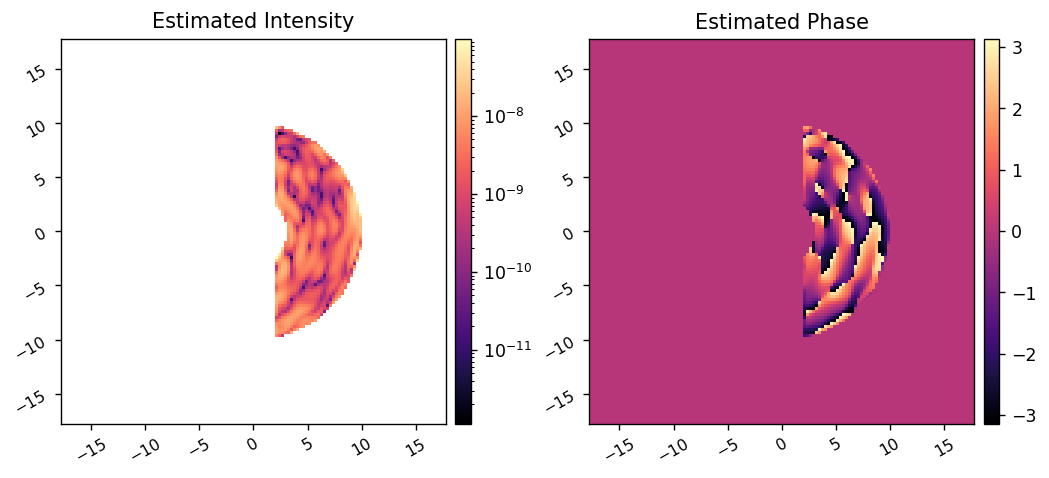

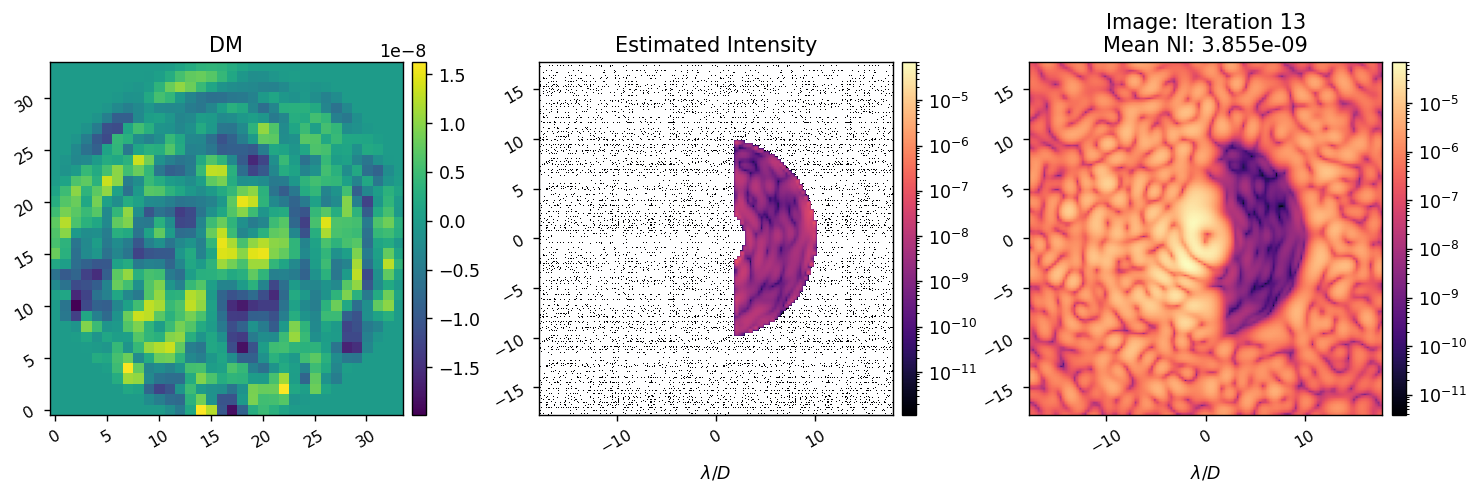

	Running iteration 14/15.


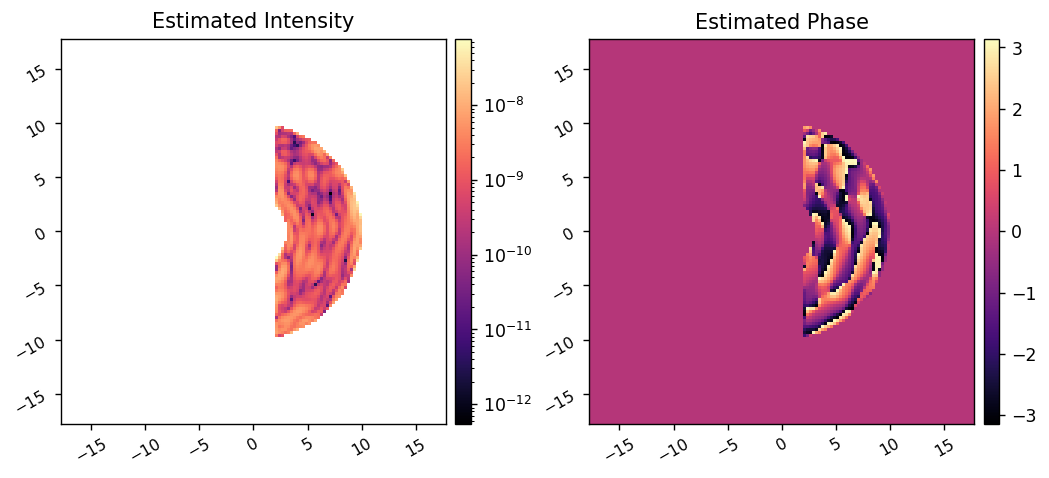

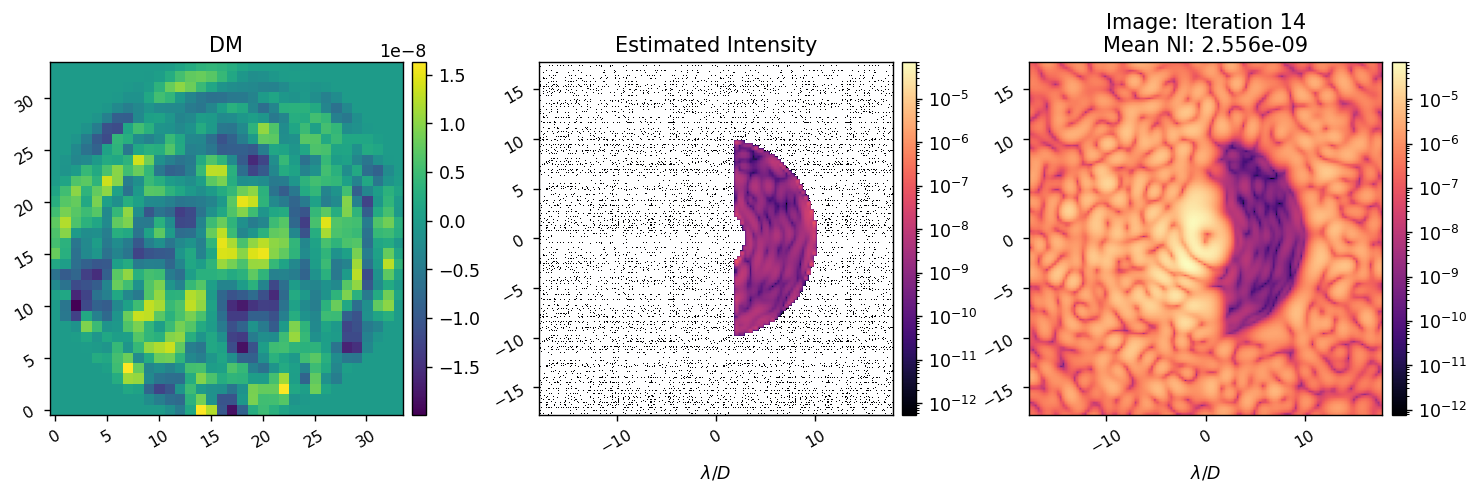

	Running iteration 15/15.


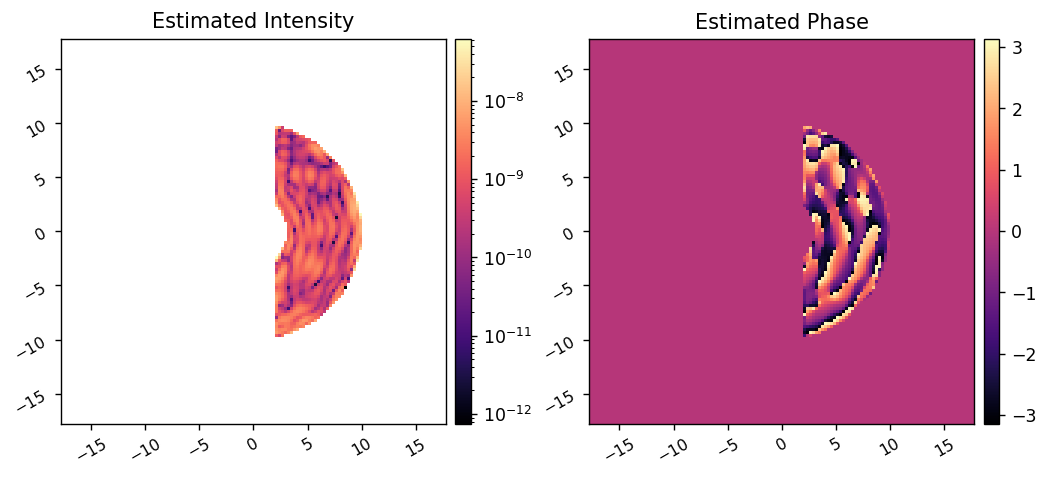

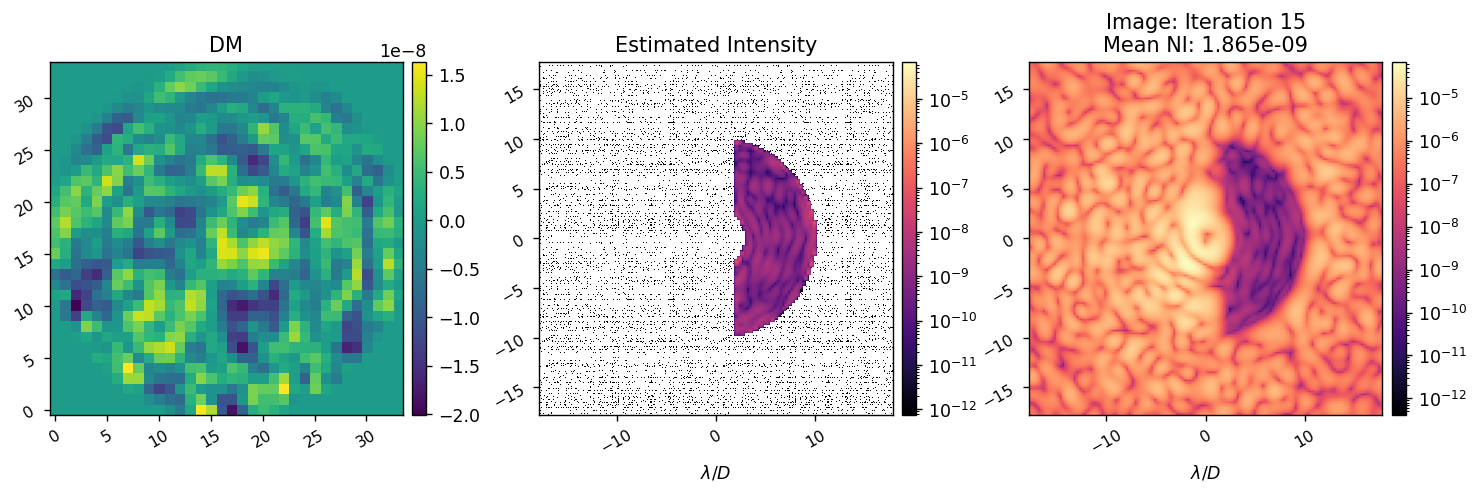

EFC completed in 37.857 sec.


In [39]:

images, estimates, dm_commands = lina.efc.run_efc_pwp(coro, 
                                                    pwp_fun, pwp_params,
                                                    jac,
                                                    poke_modes,
                                                    control_matrix, 
                                                    control_mask, 
                                                    loop_gain=0.5,
                                                    iterations=5,
                                                    plot_all=True,
                                                    # plot_sms=True,
                                                    plot_radial_contrast=False,
                                                    old_images=images,
                                                    old_estimates=estimates,
                                                    old_dm_commands=dm_commands,
                                                    )

Beginning closed-loop EFC simulation.
Max singular value squared:	 2236654514822.1577
alpha^2:			 358690673233.8554
	Running iteration 16/20.


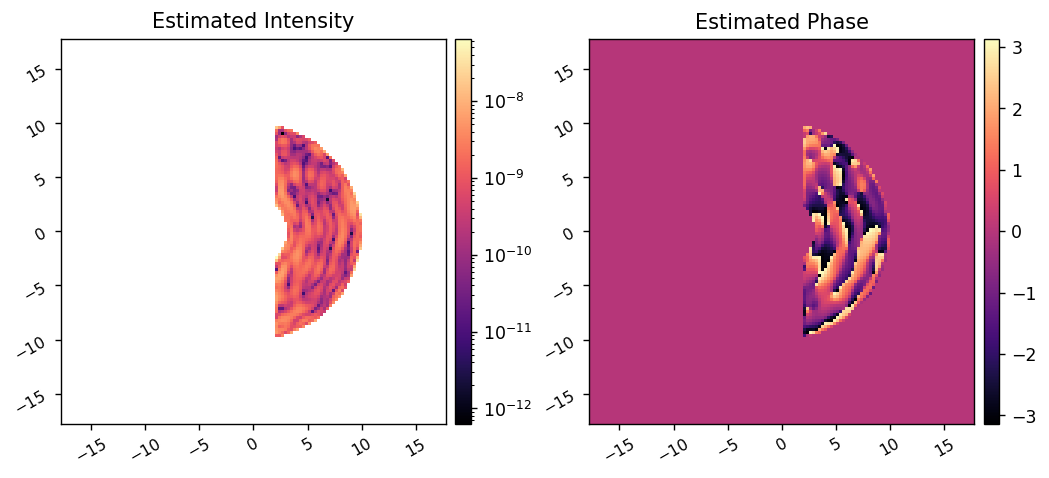

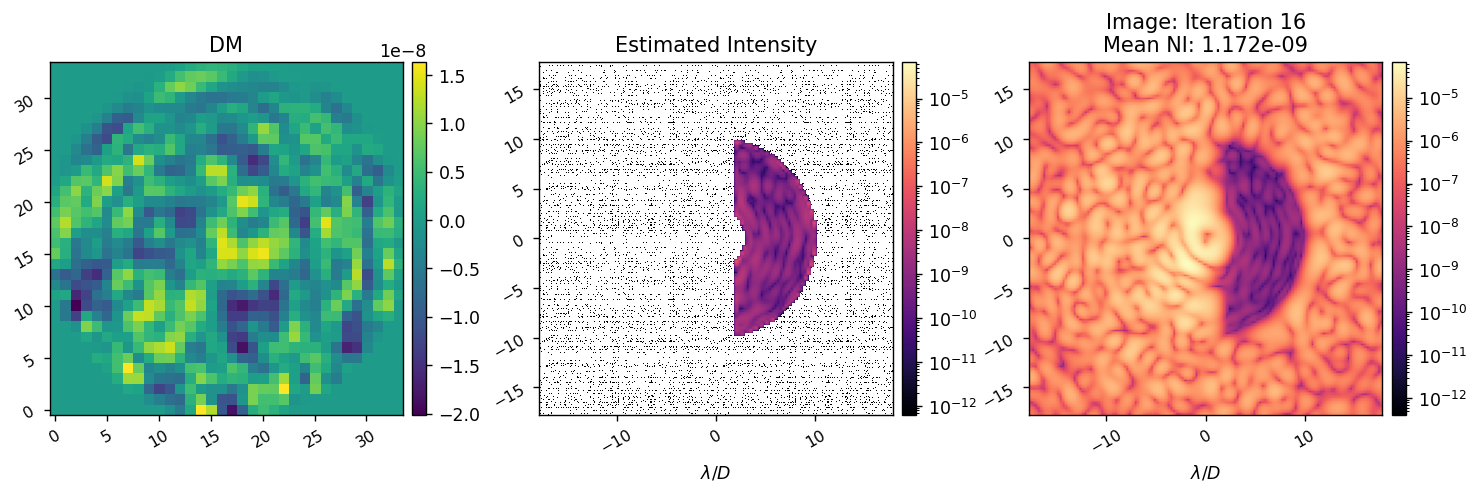

	Running iteration 17/20.


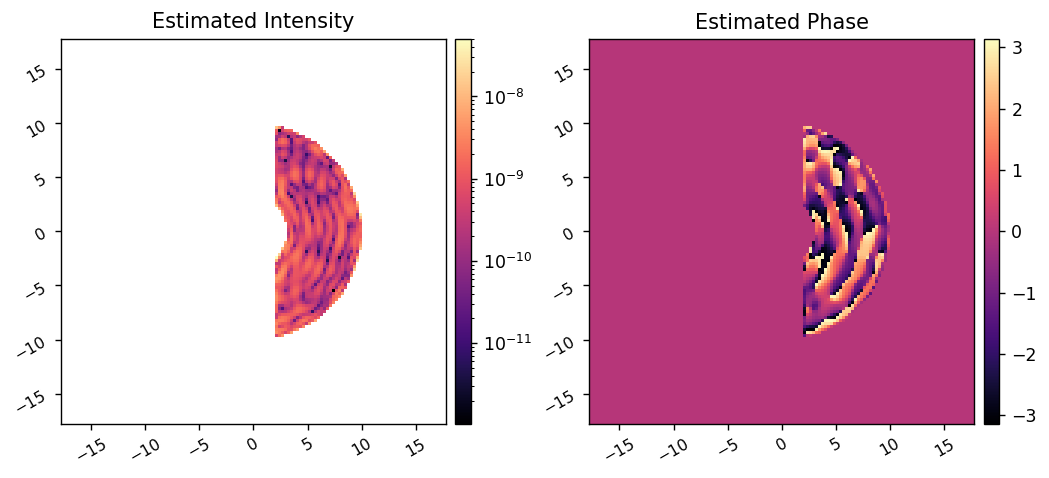

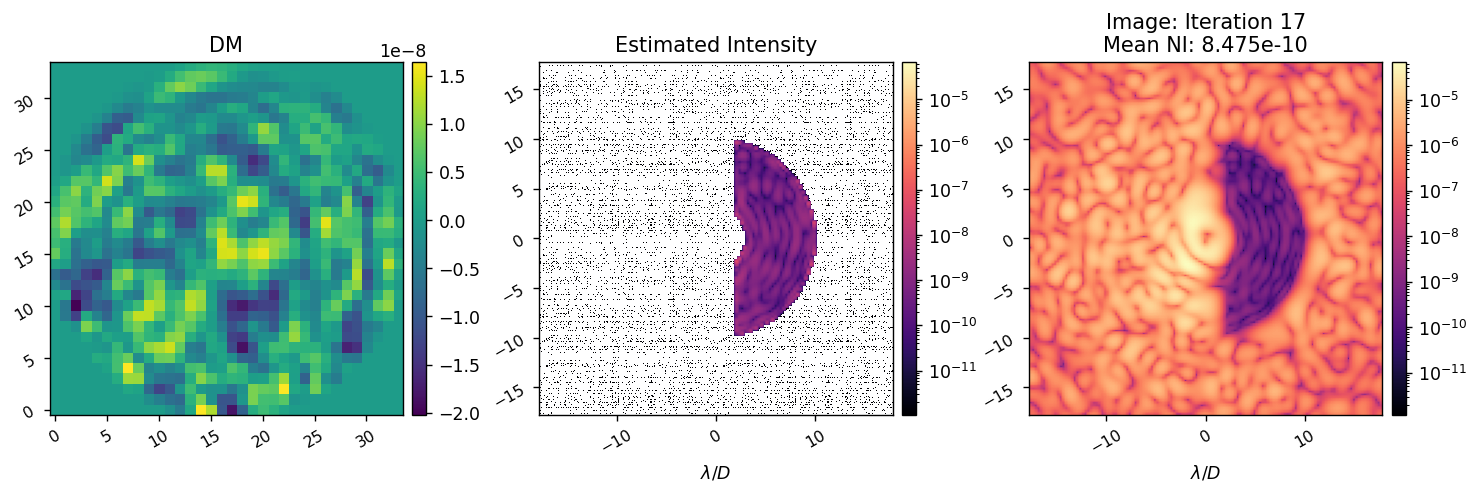

	Running iteration 18/20.


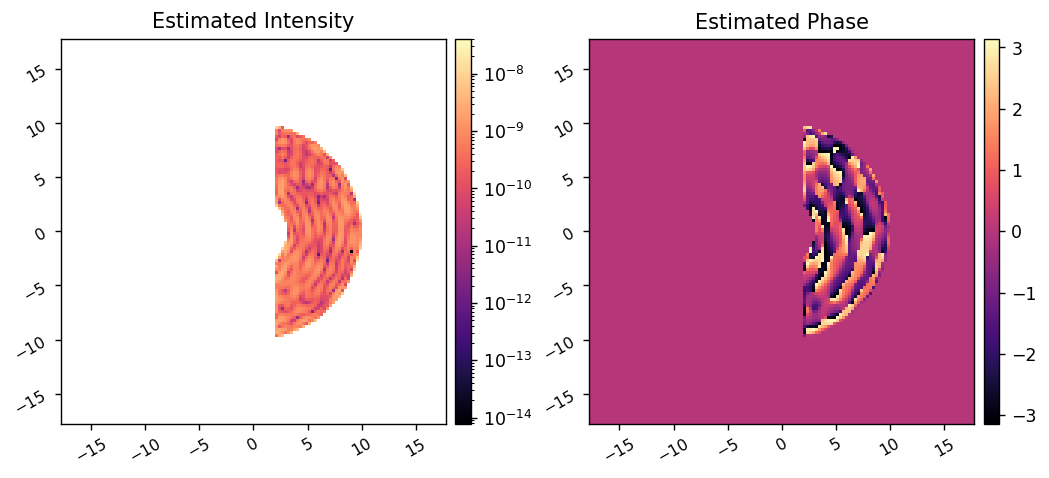

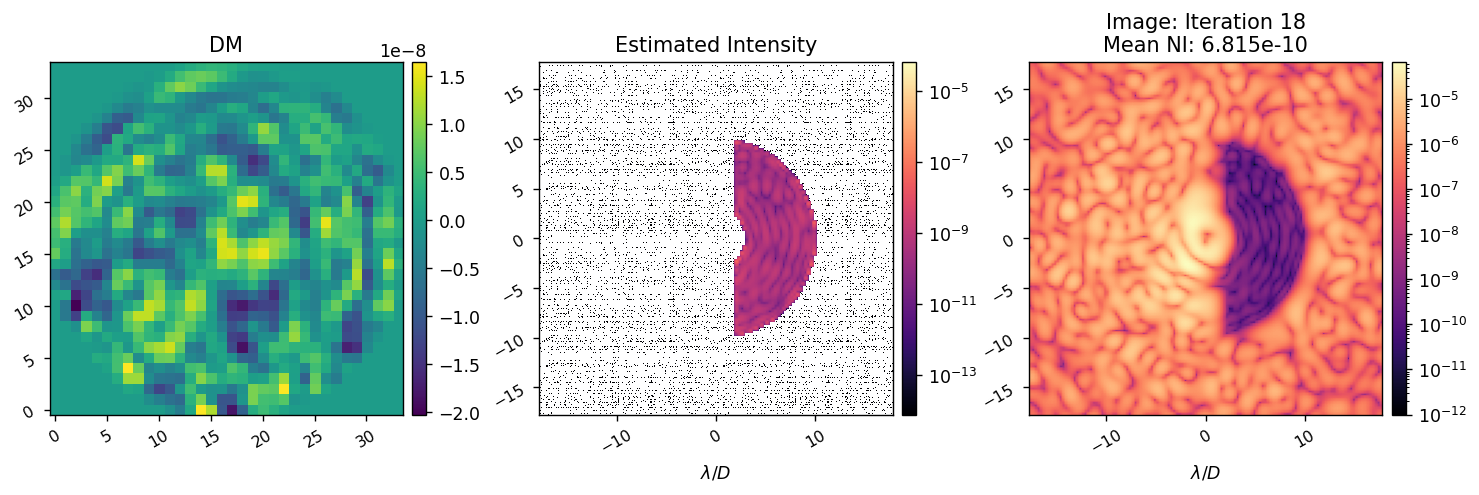

	Running iteration 19/20.


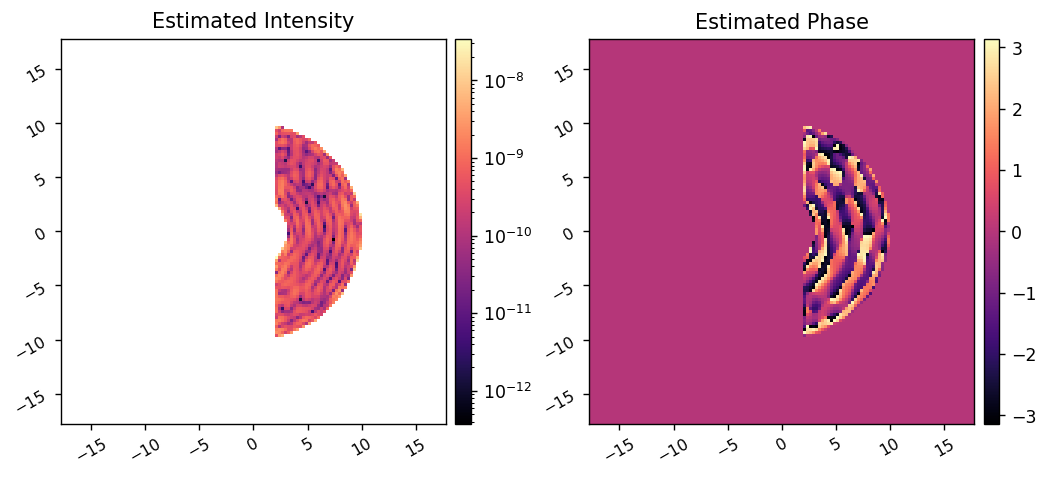

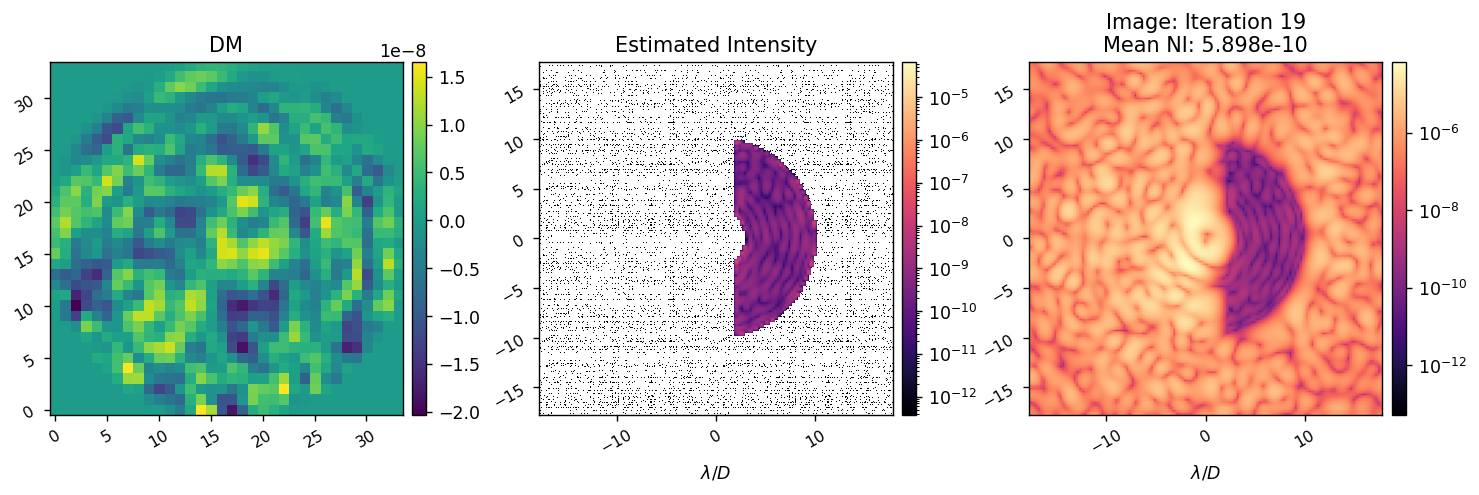

	Running iteration 20/20.


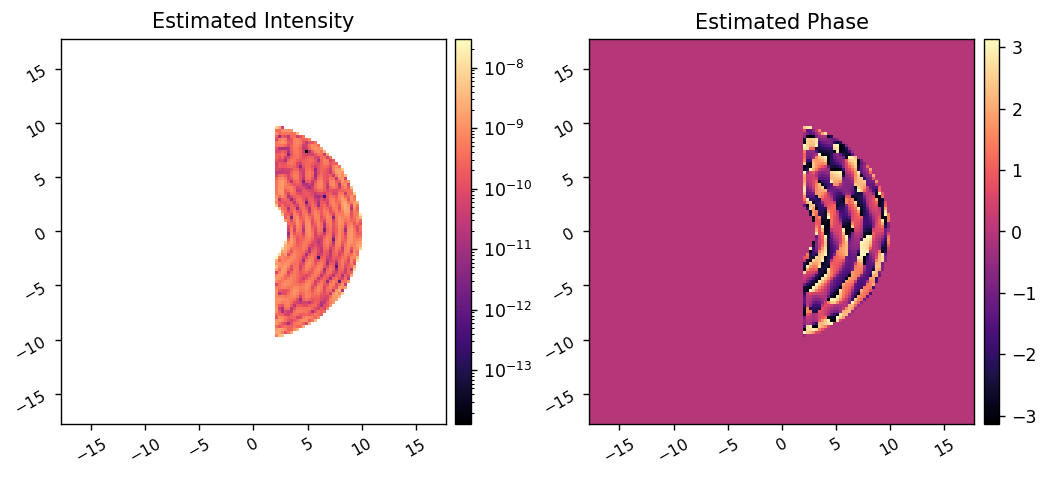

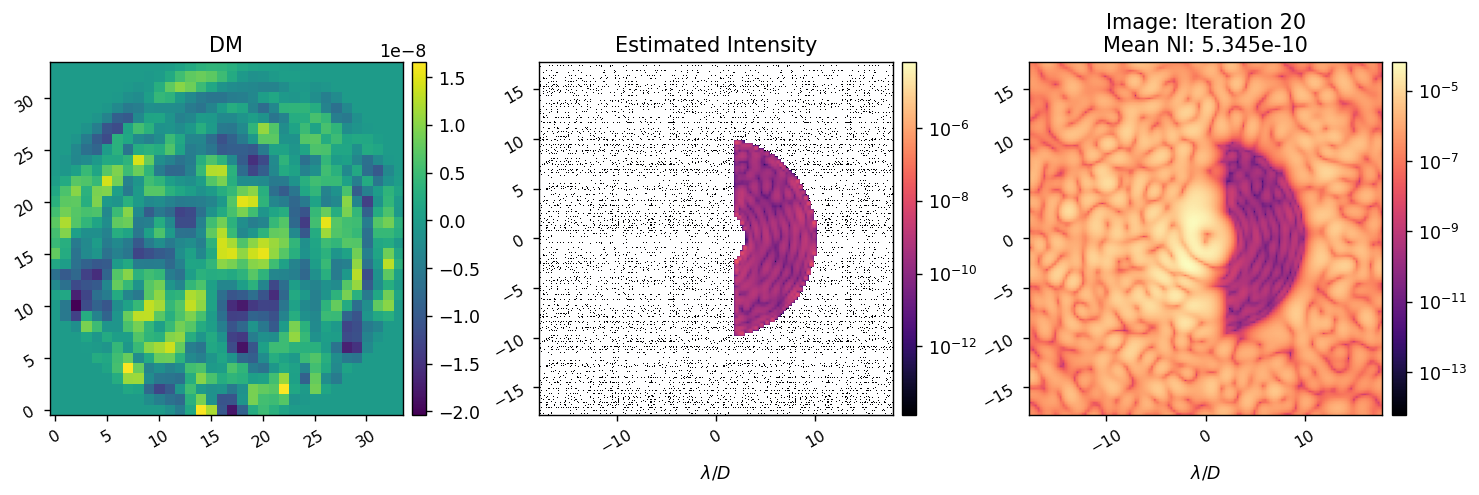

EFC completed in 37.785 sec.


In [41]:

images, estimates, dm_commands = lina.efc.run_efc_pwp(coro, 
                                                    pwp_fun, pwp_params,
                                                    jac,
                                                    poke_modes,
                                                    control_matrix, 
                                                    control_mask, 
                                                    loop_gain=0.5,
                                                    iterations=5,
                                                    plot_all=True,
                                                    # plot_sms=True,
                                                    plot_radial_contrast=False,
                                                    old_images=images,
                                                    old_estimates=estimates,
                                                    old_dm_commands=dm_commands,
                                                    )